<a href="https://colab.research.google.com/github/suyash091/BTC-Forecast/blob/master/BTC_Forecast_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from tqdm._tqdm_notebook import tqdm_notebook 

In [0]:
import numpy as np
import pandas as pd
import os
import sys
import time
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Embedding
from keras.layers import LSTM
import keras
from keras.callbacks import Callback
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import CSVLogger
from sklearn.model_selection import GridSearchCV
# import psutil
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import logging

In [0]:
df = pd.read_csv("/content/BTC-USD-3.csv")
df_date = pd.to_datetime(df['Date'])

In [39]:
df = df.set_index(df_date)
#df.reset_index().sort_values('Date', ascending=True, inplace=True)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2014-09-17,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 1526 382


In [0]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [0]:
BATCH_SIZE=64
TIME_STEPS=90

In [84]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)


length of time-series i/o (1436, 90, 5) (1436,)



length of time-series i/o (292, 90, 5) (292,)


In [62]:
x_t.shape[2]

5

In [0]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(128,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop()
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [87]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 60, 100)           40800     
_________________________________________________________________
lstm_58 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_53 (Dense)             (None, 126)               12726     
_________________________________________________________________
dense_54 (Dense)             (None, 128)               16256     
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 129       
Total params: 150,311
Trainable params: 150,311
Non-trainable params: 0
_________________________________________________________________


In [0]:
your_epochs=200

In [92]:

csv_logger = CSVLogger(os.path.join('/content/sample_data', 'your_log_name' + '.log'), append=True)

history = lstm_model.fit(x_t, y_t, epochs=your_epochs, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

Train on 1408 samples, validate on 128 samples
Epoch 1/200
 - 17s - loss: 0.0531 - val_loss: 0.0282
Epoch 2/200
 - 2s - loss: 0.0403 - val_loss: 0.0226
Epoch 3/200
 - 2s - loss: 0.0215 - val_loss: 0.0186
Epoch 4/200
 - 2s - loss: 0.0126 - val_loss: 0.0097
Epoch 5/200
 - 2s - loss: 0.0096 - val_loss: 0.0091
Epoch 6/200
 - 2s - loss: 0.0088 - val_loss: 0.0099
Epoch 7/200
 - 2s - loss: 0.0080 - val_loss: 0.0079
Epoch 8/200
 - 2s - loss: 0.0068 - val_loss: 0.0097
Epoch 9/200
 - 2s - loss: 0.0065 - val_loss: 0.0093
Epoch 10/200
 - 2s - loss: 0.0055 - val_loss: 0.0092
Epoch 11/200
 - 2s - loss: 0.0048 - val_loss: 0.0092
Epoch 12/200
 - 2s - loss: 0.0046 - val_loss: 0.0135
Epoch 13/200
 - 2s - loss: 0.0042 - val_loss: 0.0122
Epoch 14/200
 - 2s - loss: 0.0037 - val_loss: 0.0122
Epoch 15/200
 - 2s - loss: 0.0035 - val_loss: 0.0127
Epoch 16/200
 - 2s - loss: 0.0034 - val_loss: 0.0126
Epoch 17/200
 - 2s - loss: 0.0026 - val_loss: 0.0167
Epoch 18/200
 - 2s - loss: 0.0025 - val_loss: 0.0049
Epoch 1

In [93]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.003370867916276597 (128,) (128,)
[0.75365084 0.76071084 0.7373797  0.7280642  0.69637924 0.6686658
 0.6697124  0.7069122  0.6960372  0.65271074 0.6343129  0.6324426
 0.669958   0.72007316 0.74433494]
[0.56962235 0.63300589 0.60981866 0.55069561 0.53858231 0.54989447
 0.60991693 0.57131138 0.55904502 0.57095491 0.58349657 0.62672336
 0.6416232  0.62002305 0.57872493]
[14738.107 14874.501 14423.761 14243.791 13631.66  13096.256 13116.476
 13835.149 13625.052 12788.015 12432.582 12396.449 13121.22  14089.41
 14558.13 ]
[11182.806641 12407.332031 11959.371094 10817.155273 10583.134766
 10801.677734 11961.269531 11215.4375   10978.459961 11208.550781
 11450.84668  12285.958008 12573.8125   12156.512695 11358.662109]


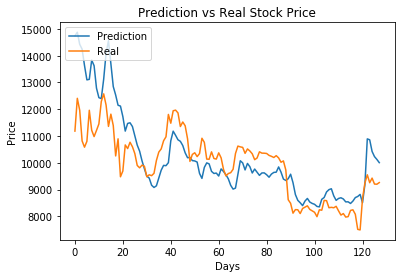

In [94]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
#plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
#print_time("program completed ", stime)